In [1]:
import os
from os import system, getpid, walk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random as python_random
import gc
from psutil import Process;
import joblib
from joblib import Parallel, delayed

from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras import mixed_precision # for support mixed precision training
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
trainPath= "/kaggle/input/optiver-trading-at-the-close/train.csv"

In [3]:
mixedPrecisionEnable = True

In [4]:
def checkMemory():
    """
    This function defines the memory usage across the kernel. 
    Source-
    https://stackoverflow.com/questions/61366458/how-to-find-memory-usage-of-kaggle-notebook
    """;
    pid = getpid();
    py = Process(pid);
    memory_use = py.memory_info()[0] / 2. ** 30;
    return f"RAM memory GB usage = {memory_use :.4}";

# For GPU Only

In [5]:
!nvidia-smi

Sun Dec 17 17:36:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

## Defining a Distribution Strategy for Tensorflow Only (Multiple GPU Acceleration)

To use Multi GPU (or multi machine, multi TPU) you will use the `tf.distribute.Strategy` API, 
more specifically `tf.distribute.MirroredStrategy`

This strategy will do the spliting of the work between both T4s for you

***Note***: You will need the context manager created here below when building the dataset and your model

In [6]:
strategy = tf.distribute.MirroredStrategy()
print('Number of GPU devices: {}'.format(strategy.num_replicas_in_sync))

Number of GPU devices: 2


# Mixed precision Training for T4 (faster training time and less memory, especail for larger model with high  N_LAGS window)
## Offical Link :  <https://keras.io/api/mixed_precision/>   <https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/Policy>

In [7]:
if mixedPrecisionEnable == True:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

In [8]:
if mixedPrecisionEnable == True:
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [9]:
### View Model Policy (mixed precision)
def modelPolicy(model):
    # Iterate over each layer in the model
    for layer in model.layers:
        # Print the name of the layer followed by its dtype policy
        print(f"{layer.name:20} {layer.dtype_policy}")

In [10]:
SEED = 42

N_LAGS =    20#12#6#3 #30 #4#20#55#10 #4 # 2 # define window size(N_Lags + 1)

BATCH_SIZE =   32 #64
BUFFER_SIZE = 100000 # for shuff function 
EPOCHS =   300 # 1000 #500
PATIENCE =  10#5
DROPOUT = 0.5#0.4#0.8#0.5
LEARNING_RATE = 1e-4

SPLIT_DAY = 390 #set split day 

# STUDY_PERIOD_DAYS = 200 # for evaluation only
# TRAINING_DAYS = 150    # for evaluaton only
# TESTING_DAYS = 50      # for evalution only

N_STOCKS = 200  # define the maximum stock id 
N_DATES = 481 # define the maximum stock dates
N_SECONDS = 55  # define the maximum seconds 0- 540 second for each day


RUN_TRAINING = True
RUN_FOR_SUBMISSION = True

In [11]:
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.keras.utils.set_random_seed(SEED)

In [12]:
%%time
# df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")
df = pd.read_csv(trainPath, engine="pyarrow") # use Multiple thread reading CSV file
df = df[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df.shape

CPU times: user 8.93 s, sys: 3.27 s, total: 12.2 s
Wall time: 8.29 s


(5237980, 4)

In [13]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    return df

df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 159.85 MB
Memory usage after optimization is: 49.95 MB
Decreased by 68.75%


# Estimate Function for how much calculation power requirement in FLOPS (For Tensorflow Model) : Avoid use this function force down to Tensorflow v1.x, create a lot of bug during training

In [14]:
# def get_flops_model(model):
#     tf.compat.v1.disable_eager_execution()
#     session = tf.compat.v1.Session()
#     graph = tf.compat.v1.get_default_graph()
        
    
#     with graph.as_default():
#         with session.as_default():
#             model = model

#             run_meta = tf.compat.v1.RunMetadata()
#             opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
#             # We use the Keras session graph in the call to the profiler.
#             flops = tf.compat.v1.profiler.profile(graph=graph,
#                                                   run_meta=run_meta, cmd='op', options=opts)
            
        
#             return flops.total_float_ops /1e9

In [15]:
 checkMemory()

'RAM memory GB usage = 3.525'

The following step is to create a DataFrame that includes all possible combinations of stock IDs, date IDs, and time intervals (in seconds). This ensures that the DataFrame contains a complete set of data across the specified ranges and intervals, with any missing data points filled with zeros.

In [16]:
all_stock_ids = range(N_STOCKS)
all_date_ids = range(N_DATES) 
all_seconds = [i * 10 for i in range(N_SECONDS)]

#Re-index full dataframe 
multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])
df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
df_full = df_full.fillna(0) # fill NA (miss value) into 0 
df_full = df_full.reset_index()
assert(df_full.shape[0] == N_STOCKS * N_DATES * N_SECONDS)
df_full


,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,0,0,10,0.389814
2,0,0,20,4.220009
3,0,0,30,5.450249
4,0,0,40,3.169775
...,...,...,...,...
5290995,199,480,500,-7.209778
5290996,199,480,510,-9.750128
5290997,199,480,520,3.629923
5290998,199,480,530,4.760027


In [17]:
gc.collect()

53

## Feature understanding
**stock_id**: A unique identifier for the stock. Not all stock IDs exist in every time bucket.

**date_id**: A unique identifier for the date. Date IDs are sequential & consistent across all stocks.

**imbalance_size**: The amount unmatched at the current reference price (in USD).

**imbalance_buy_sell_flag**: An indicator reflecting the direction of auction imbalance.

- buy-side imbalance: 1
- sell-side imbalance; -1
- no imbalance; 0

**reference_price**: The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.

**matched_size**: The amount that can be matched at the current reference price (in USD).

**far_price**: The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.

**near_price**: The crossing price that will maximize the number of shares matched based auction and continuous market orders.

**[bid/ask]_price**: Price of the most competitive buy/sell level in the non-auction book.

**[bid/ask]_size**: The dollar notional amount on the most competitive buy/sell level in the non-auction book.

**wap:** The weighted average price in the non-auction book

$\frac{BidPrice*AskSize+AskPrice*BidSize}{BidSize+AskSize}$.


**seconds_in_bucket**: The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.

**target**: The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.

* The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.

* The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.

* Where t is the time at the current observation, we can define the target:

$Target = (\frac{StockWAP_{t+60}}{StockWAP_{t}} - \frac{IndexWAP_{t+60}}{IndexWAP_{t}}) * 10000$

# Detail for Close Auction Stock trading 
### Tutorial Link :<https://www.kaggle.com/code/tomforbes/optiver-trading-at-the-close-introduction>

# EDA analysis

In [18]:
def visualize(df, stock_id, date_id):
    df1 = df[(df.stock_id == stock_id) & (df.date_id == date_id)].copy()
    df1.plot(x="seconds_in_bucket", y=["bid_price", "ask_price", "far_price", "near_price", "reference_price"])
    plt.title("bid_price, ask_price, far_price, near_price")
    plt.show()
    df1.plot(x="seconds_in_bucket", y=["bid_price","ask_price", "wap", "reference_price"])
    plt.title("bid_price, ask_price, wap, refence_price")
    plt.show()
    df1.plot(x="seconds_in_bucket", y=["target"])
    plt.title("target")
    plt.show()
    df1.plot(x="seconds_in_bucket", y=["bid_size", "ask_size"])
    plt.title("bid_size, ask_size")
    plt.show()
    df1.plot(x="seconds_in_bucket", y=['imbalance_size','matched_size'])
    plt.title("Imbalance_size, matched_size")
    plt.show()

# Create Training Dataset with tensorflow Dataset Framework

This function windowed_dataset takes a time series data, converts it into a TensorFlow Dataset, and processes it into overlapping windows. Each window contains a sequence of data points for the model to learn from (features) and the next data point as the target (label). The dataset is then batched and prefetched for efficient training.

In [19]:
def windowed_dataset(series, window_size=N_LAGS, batch_size=BATCH_SIZE):
#     series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [20]:
def windowed_dataset2(dataset, shuffle=True):
#     dataset = tf.expand_dims(dataset, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

The function build_features takes a DataFrame containing time series data for various stocks and transforms it into a pivoted format suitable for time series analysis and modeling. The function ensures comprehensive coverage by including all combinations of stock IDs, date IDs, and time intervals, and then restructures the data into a pivot table format.

In [21]:
def build_features(df):
    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique() # find unqiue date id 
    all_seconds = [i * 10 for i in range(N_SECONDS)]
    
    # Set multi-index (stock_id, date_id, seconds_in_bucket)
    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0) # fill missing value with 0
    df_full = df_full.reset_index()
    
    #create pivot table 
    df_pivoted = df_full.pivot_table(
                values='target',       # set each row value is taget
                index=['date_id', 'seconds_in_bucket'], # ste date_id, seconds_in_bucket for index 
                columns='stock_id')   # set stock_id  for column 

    df_pivoted = df_pivoted.reset_index(drop=True) # remove new date_id, second_in_bucket index  
    df_pivoted.columns.name = None  # remove column name
    
    return df_pivoted


testFeature = build_features(df_full)
testFeature

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-3.029704,-5.519986,-8.389950,-4.010201,-7.349849,6.779432,-2.499819,-1.959801,-5.970001,7.970333,...,6.370544,11.940002,-11.529922,-6.489754,3.999472,-0.690222,-0.810027,-8.440018,-0.510216,0.000000
1,0.389814,-1.620054,-7.460117,-1.040101,-6.719828,7.710457,-4.280210,-8.010268,-0.780225,-0.640154,...,4.210472,2.599955,-15.599728,-1.749992,-9.030104,-1.320243,-3.259778,-4.410148,-1.419783,0.000000
2,4.220009,-6.459951,-6.380081,-2.030134,-0.690222,1.009703,2.930164,-12.069941,-4.119873,-3.250241,...,5.379915,-5.970001,-12.710094,2.160072,-9.999871,5.890131,-0.029802,-6.819963,2.599955,0.000000
3,5.450249,-5.149841,-5.819798,1.130104,-2.589822,-3.089905,0.560284,-6.909966,-1.090169,-6.759763,...,-3.269911,1.300573,-16.660095,4.090071,-9.340048,7.020235,1.549721,1.690388,3.010035,0.000000
4,3.169775,-6.750226,-0.280142,-2.350211,-4.900098,-2.070069,2.199411,-1.209974,-3.100038,-8.199811,...,-2.009869,-0.969768,-9.229779,5.700588,-11.489987,4.500151,-1.350045,-1.929998,4.669428,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,3.999472,2.850294,-4.450083,1.720190,1.939535,-4.569888,-0.630021,-1.729727,-0.680089,3.540516,...,-4.730225,-7.420182,2.959967,-2.359748,-0.650287,3.190041,-1.659989,-0.690222,-2.700090,-7.209778
26451,3.190041,3.169775,-5.559921,4.669428,2.139807,1.679659,-0.360012,-3.240108,2.609491,1.679659,...,-3.340244,-3.479719,1.419783,-1.069903,2.319813,3.770590,-3.039837,-3.299713,-2.070069,-9.750128
26452,-0.169873,5.689859,-5.310178,5.639791,1.660585,2.110004,-1.000166,-4.529953,5.409718,0.350475,...,-1.549721,-1.289845,-0.140071,-1.929998,4.609823,1.449585,-6.319880,-1.999736,-2.239943,3.629923
26453,3.110170,10.650158,-5.239844,5.229712,0.300407,-2.030134,-1.180172,-1.310110,3.240108,0.220537,...,-1.440048,-0.299811,-2.120137,-1.350045,3.110170,4.019737,-7.349849,-3.259778,-3.160238,4.760027


In [22]:
# testDF
# testWindow = windowed_dataset(testFeature)
# testWindow

In [23]:
# testDF.head(56)

In [24]:
gc.collect()

0

# LSTM Model

In [25]:
def build_model(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)) # for new version tensorflow
    return model

In [26]:
# dataset = windowed_dataset(features, N_LAGS, BATCH_SIZE)

In [27]:
def build_model2(dropout=DROPOUT):
    # must add return sequence=True for multiple level LSTM 
    model = tf.keras.models.Sequential([
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='relu',
                                                        return_sequences=True), input_shape=(N_LAGS, N_STOCKS)), #, return_sequences=True),
    tf.keras.layers.LSTM(64, activation='relu'),
    #         tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(N_STOCKS, activation = 'linear')
    ])
    model.compile(  
#                     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                     optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), # for new version tensorflow
                       loss="mae", metrics=["mae"])
    return model

In [28]:
def build_model3(dropout=DROPOUT):
    # must add return sequence=True for multiple level LSTM 
    model = tf.keras.models.Sequential([
    
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
#                                   input_shape=(N_LAGS, N_STOCKS)),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, 
                                  input_shape=(N_LAGS, N_STOCKS)),
    tf.keras.layers.LSTM(64, activation='relu'),
        #         tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(N_STOCKS, activation = 'linear')
    ])
    model.compile( 
#                     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), # for new version tensorflow
                       loss="mae", metrics=["mae"])
    return model

In [29]:
# Define the BLSTM model
def build_model4(dropout=DROPOUT):
    model = Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True), input_shape=(N_LAGS, N_STOCKS)))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation = 'relu'))),
    model.add(Dense(1))  # Output layer for regression

    # Compile the model
    model.compile(optimizer='adam', loss='mae')
    return model

# LSTM Autoencoder
### tutorial: A Gentle Introduction to LSTM Autoencoders <https://machinelearningmastery.com/lstm-autoencoders/>
### Paper : Hybrid Variational Autoencoder for Time Series Forecasting <https://arxiv.org/pdf/2303.07048.pdf>
### Sample Code : <https://www.kaggle.com/code/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders>

In [30]:
# Define the LSTM AutoEncoder model
def build_model5(dropout=DROPOUT):
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, 
                                  input_shape=(N_LAGS, N_STOCKS), dropout=dropout),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.RepeatVector(N_LAGS),
    #     tf.keras.layers.Dropout(dropout),
    tf.keras.layers.LSTM(16, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(N_STOCKS, activation = 'linear')
    ])
    model.compile( 
#                     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), # for new version tensorflow
                       loss="mae", metrics=["mae"])
    return model

# Bidirectional LSTM Autoencoder
### Paper: [Bidirectional Convolutional LSTM Autoencoder for Risk Detection](https://www.researchgate.net/profile/Khalid-Housni/publication/345388250_Bidirectional_Convolutional_LSTM_Autoencoder_for_Risk_Detection/links/5fa5694692851cc286993a66/Bidirectional-Convolutional-LSTM-Autoencoder-for-Risk-Detection.pdf) 

### Paper: [A Bi-LSTM Autoencoder Framework for Anomaly Detection – A Case Study of a Wind Power Dataset](https://arxiv.org/pdf/2303.09703.pdf)

### Paper: [Bi-LSTM-Based Deep Stacked Sequence-to-Sequence Autoencoder for Forecasting Solar Irradiation and Wind Speed](https://www.techscience.com/cmc/v75n3/52626/pdf)

In [31]:
# Define the BiDirectional LSTM AutoEncoder model
def build_model6(dropout=DROPOUT):
    model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, 
#                                   input_shape=(N_LAGS, N_STOCKS), dropout=dropout),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                        return_sequences=True,  dropout=dropout), input_shape=(N_LAGS, N_STOCKS)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.RepeatVector(N_LAGS),
    #     tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=False)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(N_STOCKS, activation = 'linear')
    ])
    model.compile( 
#                     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), # for new version tensorflow
                       loss="mae", metrics=["mae"])
    return model

In [32]:
# with strategy.scope():
#     model1 = build_model()
# model1.summary()
# modelPolicy(model1)
# result = get_flops_model(model1)
# print("\n\rResult:", result, " GFLOPS")

In [33]:
# with strategy.scope():
#     model2 = build_model2()
# model2.summary()
# modelPolicy(model2)
# result = get_flops_model(model2)
# print("\n\rResult:", result, " GFLOPS")

In [34]:
# with strategy.scope(): # for multiple GPU
#     model3 = build_model3()
# model3.summary()
# modelPolicy(model3)
# result = get_flops_model(model3)
# print("\n\rResult:", result, " GFLOPS")

In [35]:
# with strategy.scope():
#     model4 = build_model4()
# model4.summary()
# modelPolicy(model4)
# result = get_flops_model(model4)
# print("\n\rResult:", result, " GFLOPS")

In [36]:
# with strategy.scope():
#     model5 = build_model5() # for Autoencoder
# model5.summary()
# modelPolicy(model5)

In [37]:
# with strategy.scope():
#     model6 = build_model6() # for Autoencoder
# model6.summary()
# modelPolicy(model6)

# Train/Validation/Test Evaluation

In [38]:
# %%time
# if RUN_EVALUATION:

#     TOTAL_STUDY_PERIOD = (len(set(df_full.date_id)) - STUDY_PERIOD_DAYS) // TESTING_DAYS

#     models = []
#     metrics = []

#     for i in range(TOTAL_STUDY_PERIOD):

#         train_start_date = i * TESTING_DAYS
#         train_end_date = train_start_date + TRAINING_DAYS

#         test_start_date = train_end_date
#         test_end_date = train_end_date + TESTING_DAYS

#         print(f"====== PERIOD {i} ======")

#         print(f"train_start_date: {train_start_date}, train_end_date: {train_end_date}, test_start_date: {test_start_date}, test_end_date: {test_end_date}")

#         df_train = df_full[(df_full['date_id'] >= train_start_date) & (df_full['date_id'] < train_end_date)].copy()
#         df_test = df_full[(df_full['date_id'] >= test_start_date) & (df_full['date_id'] < test_end_date)].copy()

#         df_train_features = build_features(df_train)
#         df_test_features = build_features(df_test)

#         scaler = StandardScaler()
#         train_features = scaler.fit_transform(df_train_features)
#         test_features = scaler.transform(df_test_features)

#         train_dataset = windowed_dataset(train_features, N_LAGS, BATCH_SIZE)
#         test_dataset = windowed_dataset(test_features, N_LAGS, BATCH_SIZE)

#         model = build_model2()#build_model()

#         early_stopping = EarlyStopping(monitor='val_loss',
#                           mode='min',
#                           patience=PATIENCE,
#                           restore_best_weights=True,
#                           verbose=True)

#         history = model.fit(train_dataset,
#                             validation_data=test_dataset,
#                             epochs=EPOCHS,
#                             batch_size=BATCH_SIZE,
#                             callbacks=[early_stopping],
#                             verbose=True)

#         ## Evaluate ## 
#         y_pred = model.predict(test_dataset)

#         y_pred = scaler.inverse_transform(y_pred)
#         y_true = scaler.inverse_transform(test_features)

#         mae = mean_absolute_error(y_true[N_LAGS:], y_pred)
#         print(f"MAE score for period {i}: {mae}")

#         models.append(model)
#         metrics.append(mae)

#         ## Plots ##
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
#         plt.title('model train vs validation loss')
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'validation'], loc='upper right')
#         plt.show()
        
#     df_metrics = pd.DataFrame(metrics, index=range(TOTAL_STUDY_PERIOD), columns=['MAE'])
#     mean_score = sum(metrics) / len(metrics)
#     std_score = pd.Series(metrics).std()
#     df_metrics.loc['Mean'] = mean_score
#     df_metrics.loc['Std'] = std_score
    
#     print(df_metrics)

# else:
#     print("Sliding Window Evaluation skipped")
    

In [39]:
gc.collect()

0

# Dataset Training  with K-Fold Cross validation  
### detail reference :
https://www.kaggle.com/code/sunghoshim/optiver-cross-validation-strategies#TimeSeriesSplit

In [40]:
# %%time 
# if RUN_TRAINING:
#     # split data 
#     split = df_full['date_id'] > SPLIT_DAY
#     df_train = df_full[~split]
#     df_valid = df_full[split]
    
#     df_train_features = build_features(df_train)
#     df_valid_features = build_features(df_valid)

#     scaler = StandardScaler()
#     train_features = scaler.fit_transform(df_train_features)
#     valid_features = scaler.transform(df_valid_features)
 
#     train_dataset = windowed_dataset2(train_features)
#     valid_dataset = windowed_dataset2(valid_features, shuffle=False)
 
#     train_dataset = windowed_dataset(train_features)
#     with strategy.scope(): # multiple GPU 
#         model = build_model5()

#     early_stopping = EarlyStopping(monitor='val_loss',
#                       mode='min',
#                       patience=PATIENCE,
#                       restore_best_weights=True,
#                       verbose=True)

#     history = model.fit(train_dataset,
#                         validation_data=valid_dataset,
# #                         validation_split=0.1,
#                         epochs=EPOCHS,
#                         batch_size=BATCH_SIZE,
#                         callbacks=[early_stopping],
#                         verbose=True)

#     ## Evaluate ## 
#     y_pred = model.predict(valid_dataset)

#     y_pred = scaler.inverse_transform(y_pred)
#     y_true = df_valid_features[N_LAGS:]

#     mae = mean_absolute_error(y_true, y_pred)
#     print(f"MAE score: {mae}")

#     ## Plots ##
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model train vs validation loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper right')
#     plt.show()

# Full Dataset Training (No validation)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

Epoch 1/300
827/827 [==============================] - 10s 6ms/step - loss: 0.7399
Epoch 2/300
827/827 [==============================] - 4s 5ms/step - loss: 0.7289
Epoch 3/300
827/827 [==============================] - 4s 5ms/step - loss: 0.7205
Epoch 4/300
827/827 [==============================] - 5s 6ms/step - loss: 0.7144
Epoch 5/300
827/827 [==============================] - 4s 5ms/step - loss: 0.7100
Epoch 6/300
827/827 [==============================] - 4s 5ms/step - loss: 0.7068
Epoch 7/300
827/827 [==============================] - 4s 5ms/step - loss: 0.7041
Epoch 8/300
827/827 [==============================] - 4s 5ms/step - loss: 0.7020
Epoch 9/300
827/827 [==============================] - 4s 5ms/step - loss: 0.7000
Epoch 10/300
827/827 [==============================] - 4s 5ms/step - loss: 0.6985
Epoch 11/300
827/827 [==============================] - 5s 6ms/step - loss: 0.6972
Epoch 12/300
827/827 [==============================] - 4s 5ms/step - loss: 0.6960
Epoch 13/300

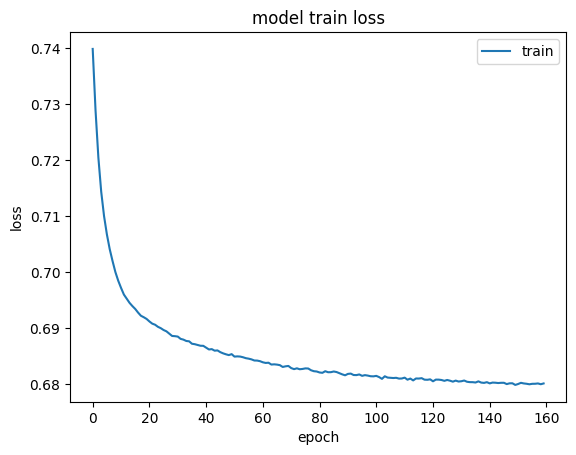

CPU times: user 28min 31s, sys: 3min 52s, total: 32min 24s
Wall time: 12min 8s


In [41]:
%%time 
if RUN_TRAINING:
    df_full_features = build_features(df_full)

    scaler = StandardScaler()
    features = scaler.fit_transform(df_full_features)
 
    dataset = windowed_dataset(features, N_LAGS, BATCH_SIZE)
#     with strategy.scope(): # multiple GPU 
    model = build_model()

    early_stopping = EarlyStopping(monitor='loss',
                      mode='min',
                      patience=PATIENCE,
                      restore_best_weights=True,
                      verbose=True)

    history = model.fit(dataset,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stopping],
                        verbose=True)

    ## Evaluate ## 
    y_pred = model.predict(dataset)

    y_pred = scaler.inverse_transform(y_pred)
    y_true = scaler.inverse_transform(features)

    mae = mean_absolute_error(y_true[N_LAGS:], y_pred)
    print(f"MAE score: {mae}")

    ## Plots ##
    plt.plot(history.history['loss'])
    plt.title('model train loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plt.show()

In [42]:
gc.collect()

7068

# Submission 

In [43]:
if RUN_FOR_SUBMISSION:
    
    import optiver2023
    optiver2023.make_env.func_dict['__called__'] = False
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    
    counter = 0
    
    for i, (test, revealed_targets, sample_prediction) in enumerate(iter_test): # reveal 3 test file 
        
#         if test.currently_scored.iloc[0]== False:  # for initial for 
#             sample_prediction['target'] = 0 # set sample prediction target value to 0
#             env.predict(sample_prediction)
#             counter += 1
#             continue        
#         if test.currently_scored.iloc[0]:
#             print(123)
        if test.seconds_in_bucket.unique()[0] == 0:
            # select used column
            df_revealed_targets = revealed_targets[["stock_id", "revealed_date_id", "seconds_in_bucket", "revealed_target"]]
            df_revealed_targets = df_revealed_targets.rename(columns={'revealed_date_id': 'date_id', 'revealed_target': 'target'})

            df_features = build_features(df_revealed_targets)  #build feature 

            history_scaled = scaler.transform(df_features) # scale the featrure 
        
        # predict the target value
#         print(123)
        y_pred_scaled = model.predict(
            history_scaled[-N_LAGS:][np.newaxis, :, :],
            verbose=True)
        
        y_pred = scaler.inverse_transform(y_pred_scaled)
        print(len(sample_prediction['target']))
        sample_prediction['target'] = y_pred[0][:len(sample_prediction['target'])].astype('float64')
        env.predict(sample_prediction)
        counter += 1
        
        history_scaled = np.concatenate([history_scaled, y_pred_scaled])

else:
    print("Run for submission skipped")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


1/1 [==============================] - 0s 355ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 24ms/step
200
1/1 [==============================] - 0s 18ms/step
200
1/1 [==============================] - 0s 20ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 20ms/step
200
1/1 [==============================] - 0s 19ms/step
200
1/1 [==============================] - 0s 19

In [44]:
# gc.collect()

In [45]:
# test.currently_scored.iloc[0]